<a href="https://colab.research.google.com/github/shiva7579/Machine_learning/blob/main/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,InputLayer,BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy,Recall,Precision,TruePositives,TrueNegatives,FalsePositives,FalseNegatives,AUC
import sklearn
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
from google.colab import drive

**Dataset**

In [2]:
dataset,dataset_info=tfds.load("malaria",with_info=True,as_supervised=True,shuffle_files=True,split=['train'])
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete62Q5NT/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

**Splitting Dataset**

In [3]:
def splits(dataset,train_ratio,val_ratio,test_ratio):
  dataset_size=len(dataset)

  train_dataset= dataset.take(int(train_ratio*dataset_size))

  val_test_dataset=dataset.skip(int(train_ratio*dataset_size))
  val_dataset=val_test_dataset.take(int(val_ratio*dataset_size))

  test_dataset=val_test_dataset.skip(int(val_ratio*dataset_size))

  return train_dataset,val_dataset,test_dataset




In [4]:
train_ratio=0.8
val_ratio=0.1
test_ratio=0.1

#dataset=tf.data.Dataset.range(10)
#list(dataset.as_numpy_iterator())

train_dataset,val_dataset,test_dataset=splits(dataset[0],train_ratio,val_ratio,test_ratio)
#print(list(train_dataset.take(1).as_numpy_iterator()))

In [5]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

**Data Visualization**

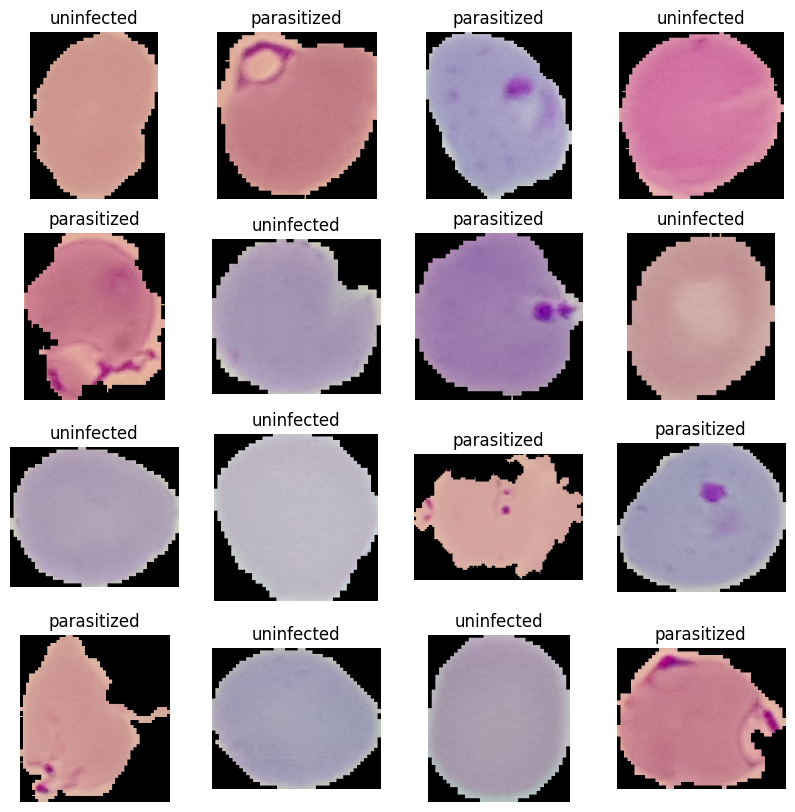

In [6]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(16)):
  plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')




**Data Processing**

In [7]:
I_m_size=224
def resize_rescale(image,label):
  return tf.image.resize(image,(I_m_size,I_m_size))/255.0,label

In [8]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


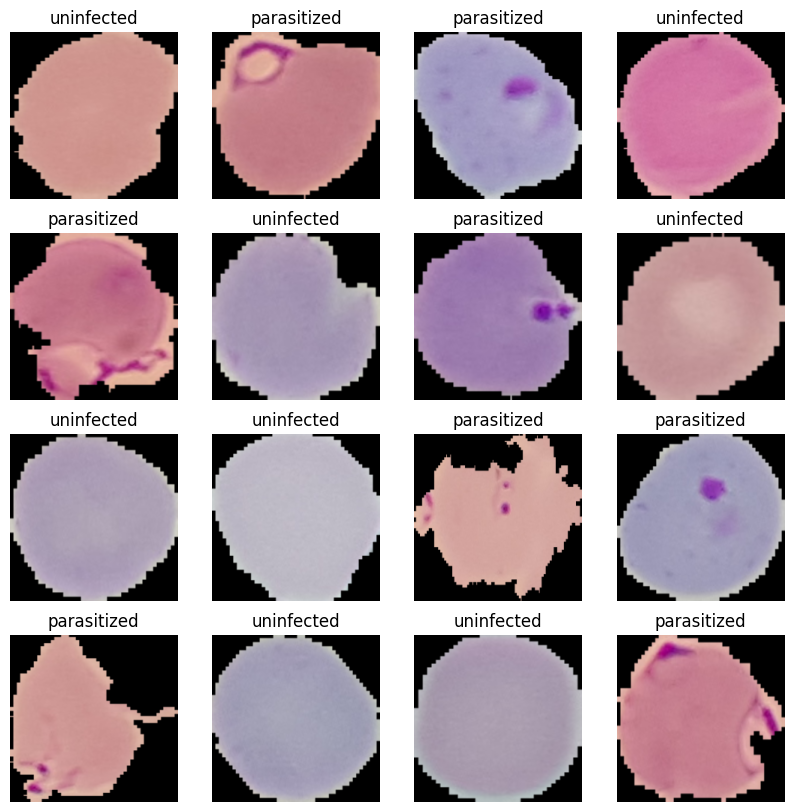

In [9]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(16)):
  plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


In [10]:
BATCH_SIZE=32
train_dataset=train_dataset.shuffle(8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(1)


Model: Lenet Model

In [11]:
model=Sequential([
                  InputLayer(input_shape=(I_m_size,I_m_size,3)),

                  tf.keras.layers.Conv2D(filters=6,kernel_size=(5,5),strides=1,padding='valid',activation='relu'),
                  BatchNormalization(),
                  tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

                  tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),strides=1,padding='valid',activation='relu'),
                  BatchNormalization(),
                  tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

                  Flatten(),
                  Dense(units=120,activation='relu'),
                  BatchNormalization(),
                  Dense(units=84,activation='relu'),
                  BatchNormalization(),
                  Dense(units=1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

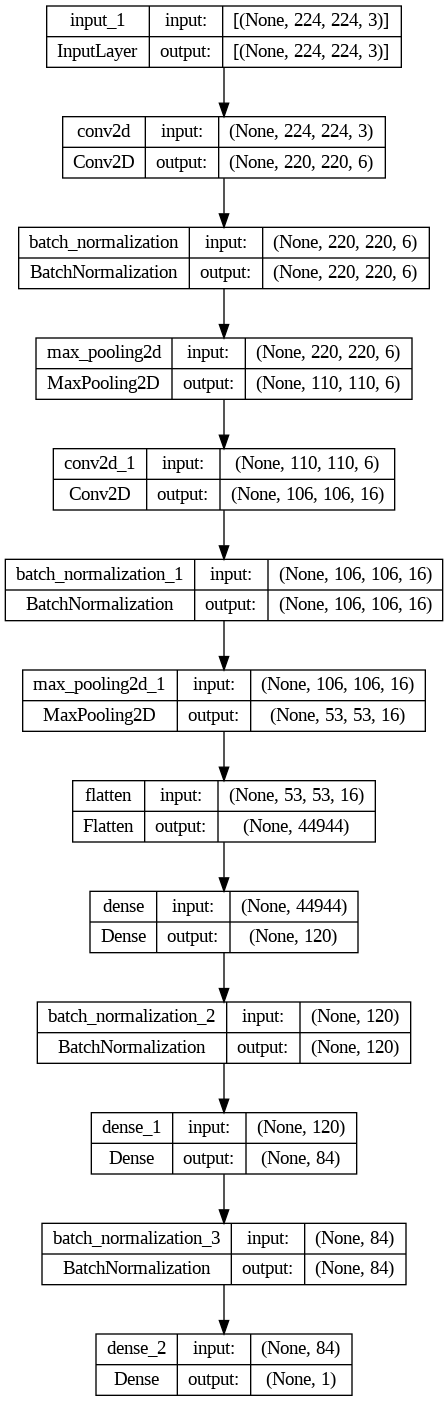

In [12]:
tf.keras.utils.plot_model(model,to_file="model.png",show_shapes=True)

In [15]:
metrics=[TruePositives(name='TP'),FalsePositives(name='FP'),TrueNegatives(name='TN'),FalseNegatives(name='FN'),Precision(name='Precision'),Recall(name="Recall"),AUC(name='AUC'),BinaryAccuracy(name='Accuracy')]

In [16]:
model.compile (optimizer= Adam(learning_rate=0.01),
               loss= BinaryCrossentropy(),
               metrics=metrics)

In [17]:
history=model.fit(train_dataset,epochs=30,validation_data=val_dataset,callbacks=EarlyStopping(patience=5,monitor='val_Accuracy'),verbose=2)

Epoch 1/30
689/689 - 60s - loss: 0.4367 - TP: 8786.0000 - FP: 2334.0000 - TN: 8689.0000 - FN: 2237.0000 - Precision: 0.7901 - Recall: 0.7971 - AUC: 0.8790 - Accuracy: 0.7927 - val_loss: 0.3062 - val_TP: 1353.0000 - val_FP: 274.0000 - val_TN: 1085.0000 - val_FN: 43.0000 - val_Precision: 0.8316 - val_Recall: 0.9692 - val_AUC: 0.9563 - val_Accuracy: 0.8849 - 60s/epoch - 87ms/step
Epoch 2/30
689/689 - 46s - loss: 0.2087 - TP: 10359.0000 - FP: 938.0000 - TN: 10085.0000 - FN: 664.0000 - Precision: 0.9170 - Recall: 0.9398 - AUC: 0.9702 - Accuracy: 0.9273 - val_loss: 0.1561 - val_TP: 1328.0000 - val_FP: 78.0000 - val_TN: 1289.0000 - val_FN: 60.0000 - val_Precision: 0.9445 - val_Recall: 0.9568 - val_AUC: 0.9825 - val_Accuracy: 0.9499 - 46s/epoch - 67ms/step
Epoch 3/30
689/689 - 45s - loss: 0.1580 - TP: 10554.0000 - FP: 717.0000 - TN: 10307.0000 - FN: 468.0000 - Precision: 0.9364 - Recall: 0.9575 - AUC: 0.9823 - Accuracy: 0.9462 - val_loss: 0.2591 - val_TP: 1354.0000 - val_FP: 141.0000 - val_TN:

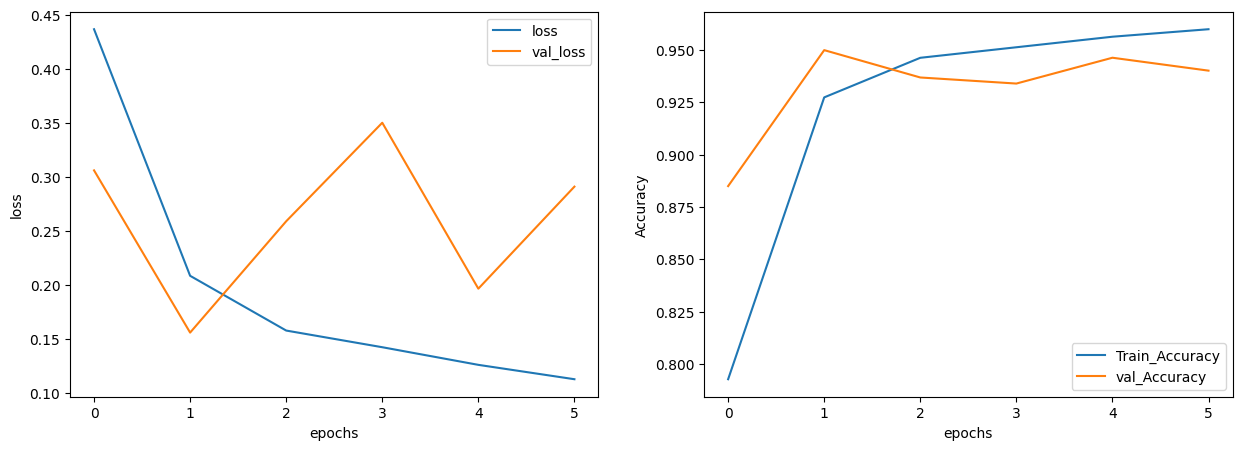

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss','val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Train_Accuracy','val_Accuracy'])

**Evaluate Model**

In [19]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 25s 5ms/step - loss: 0.3046 - TP: 1325.0000 - FP: 134.0000 - TN: 1258.0000 - FN: 40.0000 - Precision: 0.9082 - Recall: 0.9707 - AUC: 0.9714 - Accuracy: 0.9369


[0.3045749366283417,
 1325.0,
 134.0,
 1258.0,
 40.0,
 0.9081562757492065,
 0.970695972442627,
 0.9714080691337585,
 0.9368879199028015]

In [20]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 10s 10s/step


array([[0.99999964]], dtype=float32)

In [21]:
def infected_or_not(x):
  if (x<0.5):
    return str('Infected')
  else :
   return str('Healthy')
infected_or_not(model.predict(test_dataset.take(1)))

1/1 [==============================] - 11s 11s/step


'Healthy'

1/1 [==============================] - 0s 18ms/step


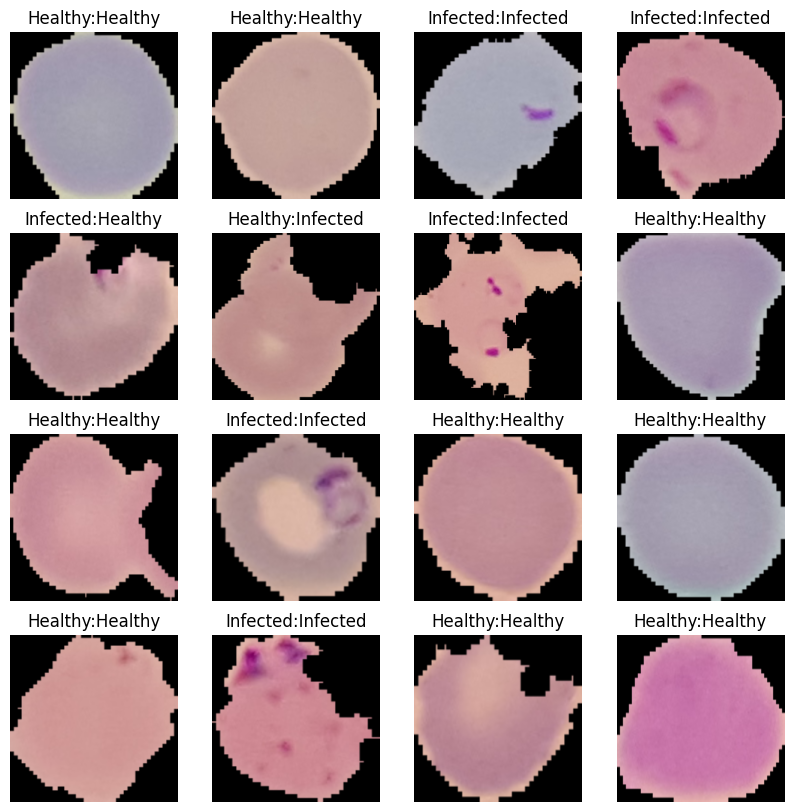

In [22]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(test_dataset.take(16)):
  plt.subplot(4,4,i+1)
  plt.imshow(image[0])
  plt.title(str(infected_or_not(label.numpy()[0]))+':'+str(infected_or_not(model.predict(image)[0][0])))
  plt.axis('off')

**Visualizing Confusion Matrix**

In [24]:
labels=[]
input=[]

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  input.append(x)

In [27]:
labels=np.array([i[0] for i in labels])
print(labels)

[0 1 0 ... 1 0 1]


In [32]:
print(np.array(input).shape)
print(np.array(input)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [35]:
predicted=model.predict(np.array(input)[:,0,...])

87/87 [==============================] - 2s 24ms/step


In [40]:
print(predicted.shape)
print(predicted[:,-1].shape)

(2757, 1)
(2757,)


In [41]:
predicted=predicted[:,-1]
print(predicted)

[0.92719686 0.9854651  0.01167772 ... 1.         0.00397413 0.9951709 ]


[[1274  119]
 [  54 1310]]


Text(0.5, 58.7222222222222, 'Predicted')

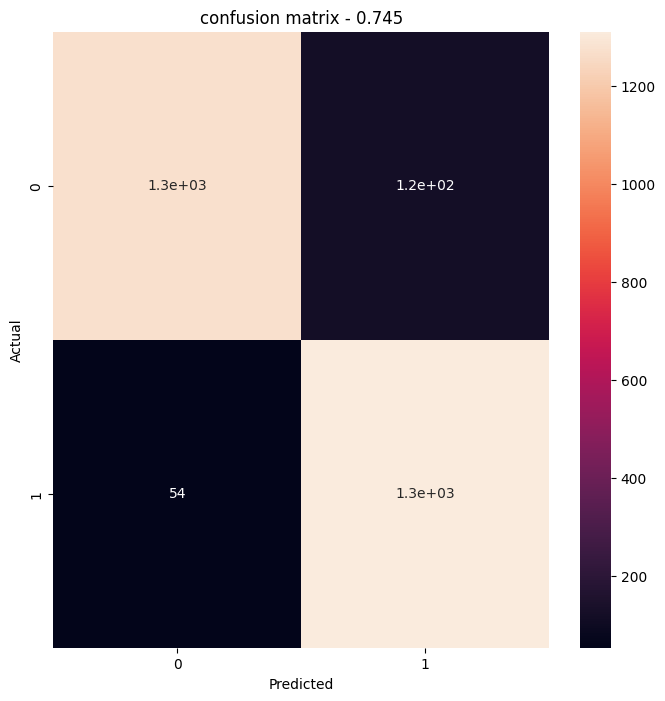

In [50]:
threshold=0.745
cm=confusion_matrix(labels,predicted>threshold)
print(cm)

plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title('confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

ROC_CURVE

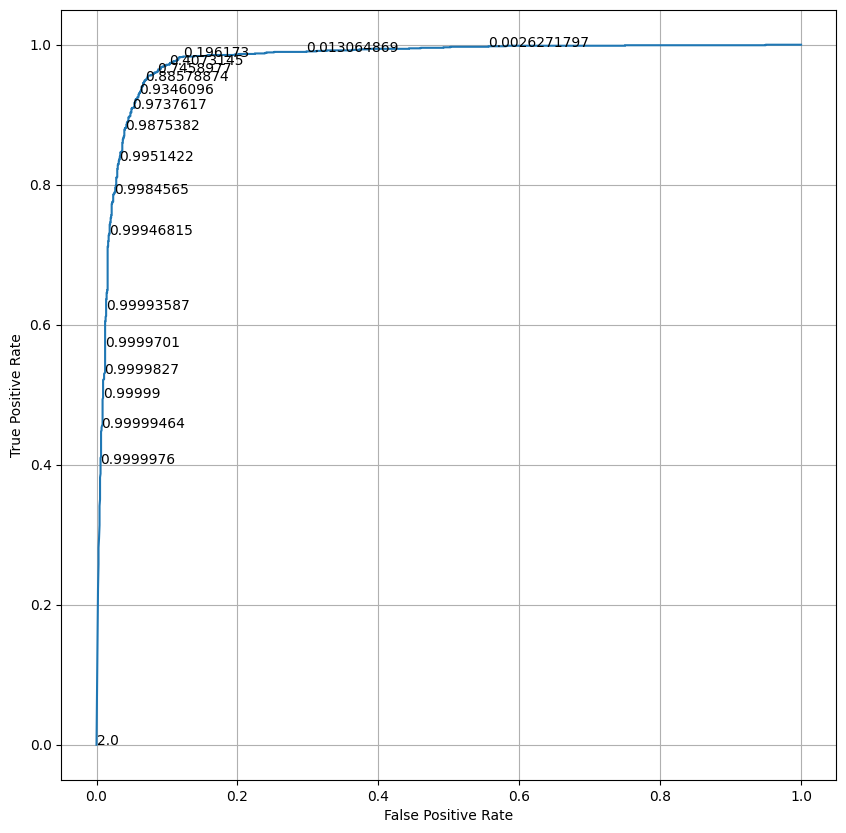

In [49]:
plt.figure(figsize=(10,10))
fp,tp,threshold=roc_curve(labels,predicted)

plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()
skip=20
for i in range(0,len(threshold),skip):
  plt.text(fp[i],tp[i],threshold[i])

plt.show()

**Loading And Saving**

In [ ]:
#model.save('malaria_prediction_model')

In [ ]:
#loaded_model=tf.keras.models.load_model('malaria_prediction_model')
#loaded_model.summary()

In [ ]:
#model.save_weights("weigths/malaria_prediction_model_weights")

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive")

In [ ]:
#!cp -r /content/drive/MyDrive/malaria_lenet/ /content/malaria_prediction_model/

In [ ]:
#!cp -r /content/weigths/ /content/drive/MyDrive/malaria_lenet/

In [ ]:
#loaded_model=tf.keras.models.load_model('malaria_prediction_model/malaria_prediction_model')
#loaded_model.summary()